# Config

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib import pyplot
from prophet import Prophet


# Main Objective

In [2]:
# Main objective of this task is to find the best method to predict future values of milk collection based on given data.

# Loading data

In [3]:
data = {
    
}

In [4]:
data["delivery"] = pd.read_excel("Delivery_data.xlsx")

In [5]:
data["delivery"].head(5)

,Farm ID,Rok,Tydzień,Start tygodnia,Ilość,y,y_raw
0,1311,2022,1,2022-01-03,8683.23,10149.08,10149.08
1,1270,2022,1,2022-01-03,4841.73,4225.18,4225.18
2,1317,2022,1,2022-01-03,12363.43,10861.82,10861.82
3,1271,2022,1,2022-01-03,3115.41,3642.37,3642.37
4,1132,2022,1,2022-01-03,925.49,1076.46,1076.46


## Translation of column names

In [6]:
data["delivery"] = data["delivery"].rename(columns= {"Tydzień" : "Week", "Start tygodnia" : "First day of the week", "Ilość":"Quantity", "Rok":"Year"})

## Brief description of data

In [7]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,Quantity,y,y_raw
0,1311,2022,1,2022-01-03,8683.23,10149.08,10149.08


In [8]:
# Farm ID is an unique indetifier to determine overall quantity of milk delivered by spiecified supplier
data["delivery"]["Farm ID"].nunique()

320

In [9]:
# Year is the year of milk delivery - between 2022 and 2024
display(data["delivery"]["Year"].nunique())
display(data["delivery"]["Year"].unique())

3

array([2022, 2023, 2024])

In [10]:
# week is the week of milk delivery - between 1 and 52
display(data["delivery"]["Week"].nunique())
display(data["delivery"]["Week"].unique())

52

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [11]:
# first day of the week is dtype datetime64[ns] object. The first day of the week delivery - between 2022-01-03 00:00:00 and 2024-12-23 00:00:00
display(data["delivery"]["First day of the week"].nunique())
display(data["delivery"]["First day of the week"].unique())

156

<DatetimeArray>
['2022-01-03 00:00:00', '2022-01-10 00:00:00', '2022-01-17 00:00:00',
 '2022-01-24 00:00:00', '2022-01-31 00:00:00', '2022-02-07 00:00:00',
 '2022-02-14 00:00:00', '2022-02-21 00:00:00', '2022-02-28 00:00:00',
 '2022-03-07 00:00:00',
 ...
 '2024-10-21 00:00:00', '2024-10-28 00:00:00', '2024-11-04 00:00:00',
 '2024-11-11 00:00:00', '2024-11-18 00:00:00', '2024-11-25 00:00:00',
 '2024-12-02 00:00:00', '2024-12-09 00:00:00', '2024-12-16 00:00:00',
 '2024-12-23 00:00:00']
Length: 156, dtype: datetime64[ns]

In [12]:
# Quantity is the "raw" data from milk collection point
display(data["delivery"]["Quantity"].mean())

np.float64(2297.9326886915383)

In [13]:
# Quantity is the data that is treated as an only daily collection cycle

display(data["delivery"]["y_raw"].mean())

np.float64(2298.5747168373996)

In [14]:
# Quantity is the data that is cleared from outliers and is treated as an only daily collection cycle
display(data["delivery"]["y"].mean())

np.float64(2299.1915784936755)

# Data exploration

In [15]:
data["delivery"].describe()

,Farm ID,Year,Week,First day of the week,Quantity,y,y_raw
count,49883.000000,49883.000000,49883.000000,49883,49883.000000,49883.000000,49883.000000
mean,1160.493836,2023.000742,26.514303,2023-06-29 20:52:58.028587008,2297.932689,2299.191578,2298.574717
min,1001.000000,2022.000000,1.000000,2022-01-03 00:00:00,84.740000,73.320000,73.320000
25%,1080.000000,2022.000000,14.000000,2022-10-03 00:00:00,695.360000,713.910000,713.495000
50%,1160.000000,2023.000000,27.000000,2023-07-03 00:00:00,1364.360000,1390.190000,1389.640000
75%,1241.000000,2024.000000,40.000000,2024-04-01 00:00:00,2567.435000,2572.530000,2570.880000
max,1320.000000,2024.000000,52.000000,2024-12-23 00:00:00,52352.600000,52241.040000,52241.040000
std,92.401104,0.816353,15.004375,NaN,3394.440341,3367.655556,3368.607343


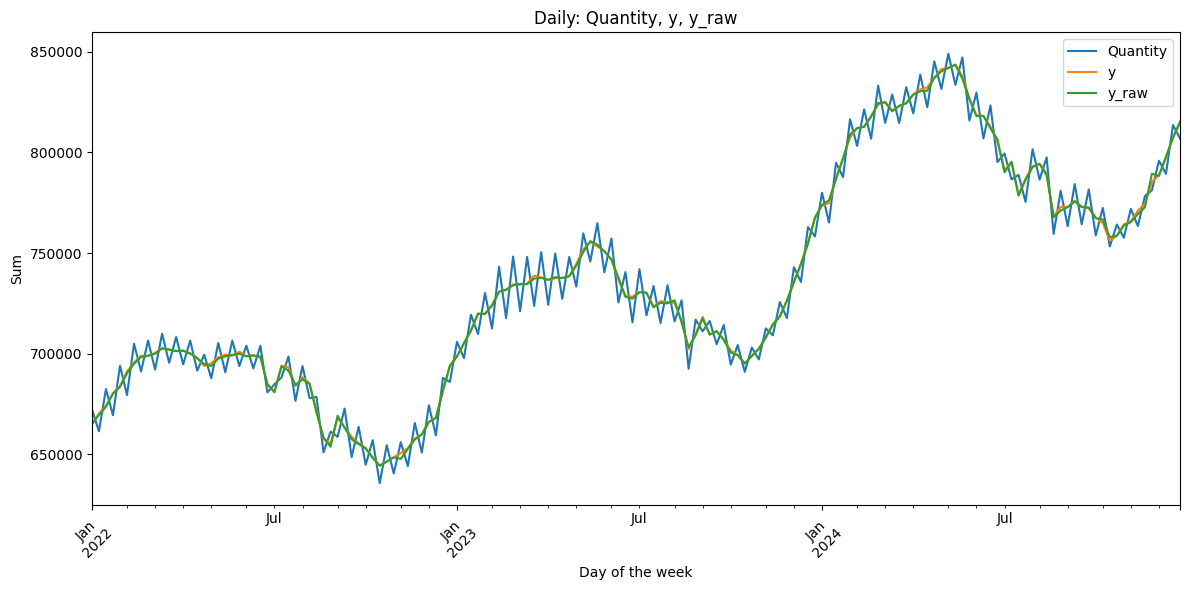

In [16]:
data["daily_sum"] = data["delivery"].groupby("First day of the week")[["Quantity", "y", "y_raw"]].sum()
data["daily_sum"].plot(kind="line", figsize=(12,6), title="Daily: Quantity, y, y_raw")
plt.xlabel("Day of the week")
plt.ylabel("Sum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
#As seen on plot above, the "quantity" behaves the worst because of spikes. Let's get rid of it

In [18]:
data["delivery"] = data["delivery"].drop(columns={"Quantity"})

In [19]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,y,y_raw
0,1311,2022,1,2022-01-03,10149.08,10149.08


In [20]:
# Let's now compare the y vs y_raw

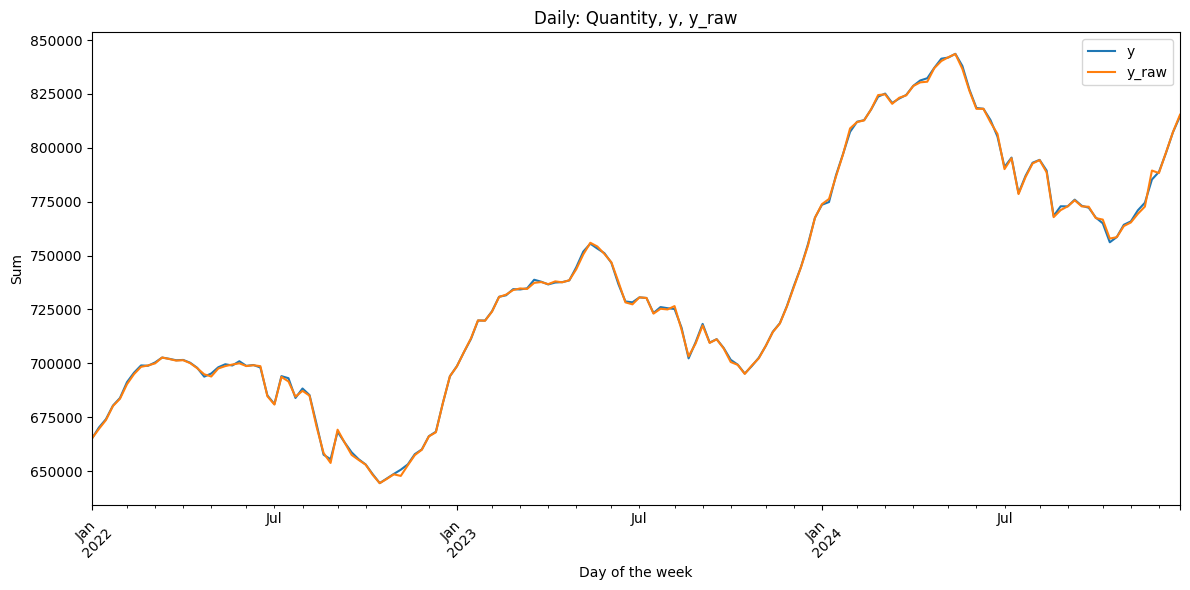

In [21]:
data["daily_sum"] = data["delivery"].groupby("First day of the week")[["y", "y_raw"]].sum()
data["daily_sum"].plot(kind="line", figsize=(12,6), title="Daily: Quantity, y, y_raw")
plt.xlabel("Day of the week")
plt.ylabel("Sum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# From my personal point of view, the "y" value seems to be better at smoothness. Let's drop y_raw

In [23]:
data["delivery"] = data["delivery"].drop(columns={"y_raw"})

In [24]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,y
0,1311,2022,1,2022-01-03,10149.08


# Time series decomposition

In [25]:
data["daily_sum"].head()

,y,y_raw
First day of the week,,
2022-01-03,665032.23,665096.87
2022-01-10,670191.95,669532.12
2022-01-17,674053.09,673657.35
2022-01-24,680375.89,680165.20
2022-01-31,683891.50,683530.08


In [26]:
decompose_mult = seasonal_decompose(data["daily_sum"]["y"], model='multiplicative')
decompose_add = seasonal_decompose(data["daily_sum"]["y"], model='additive')

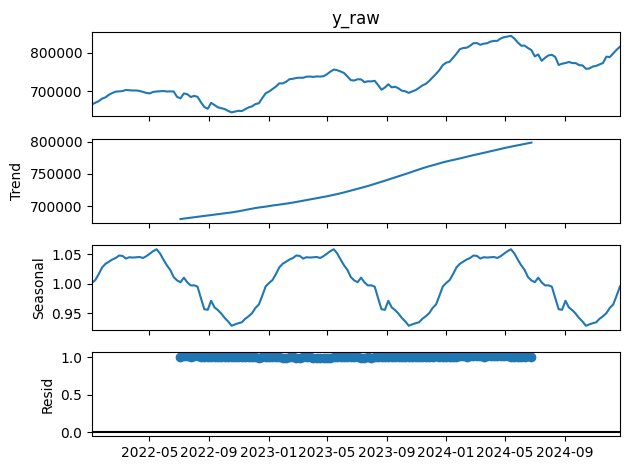

In [46]:
decompose_mult.plot()
pyplot.show()

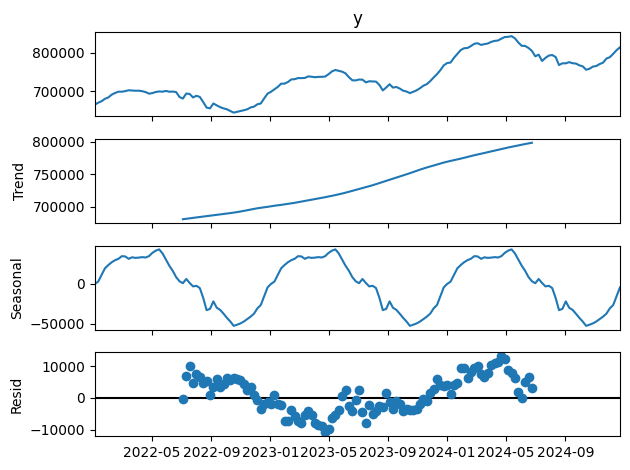

In [28]:
decompose_add.plot()
pyplot.show()

In [29]:
decompose_mult = seasonal_decompose(data["daily_sum"]["y_raw"], model='multiplicative')
decompose_add = seasonal_decompose(data["daily_sum"]["y_raw"], model='additive')

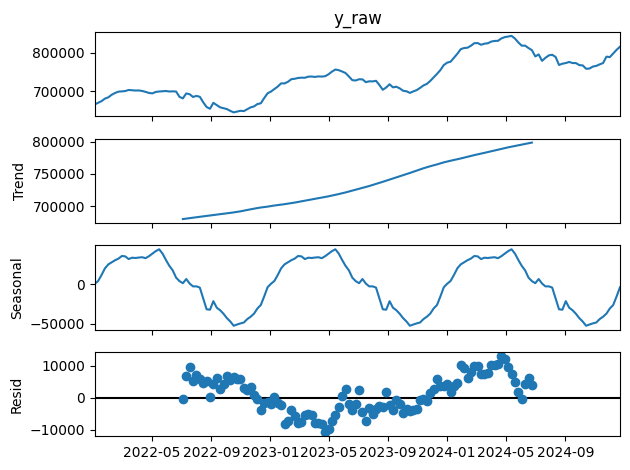

In [30]:
decompose_add.plot()
pyplot.show()

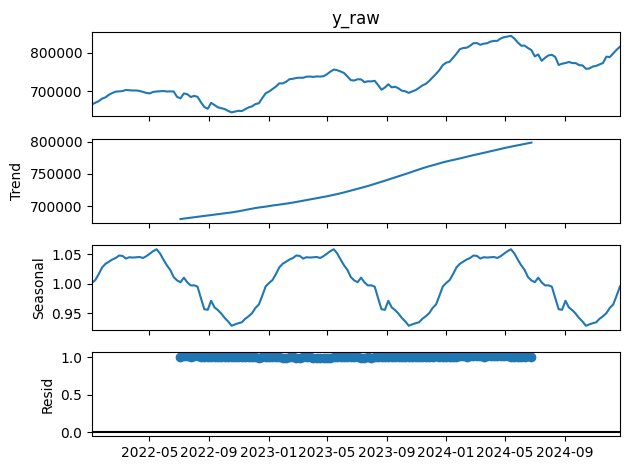

In [31]:
decompose_mult.plot()
pyplot.show()

# Time series forecasting

In [32]:
data["forecast"] = data["delivery"][['First day of the week', 'y']]

In [33]:
data["forecast"] = data["forecast"].groupby("First day of the week").sum()

In [34]:
data["forecast"].head()

,y
First day of the week,
2022-01-03,665032.23
2022-01-10,670191.95
2022-01-17,674053.09
2022-01-24,680375.89
2022-01-31,683891.50


<Axes: xlabel='First day of the week'>

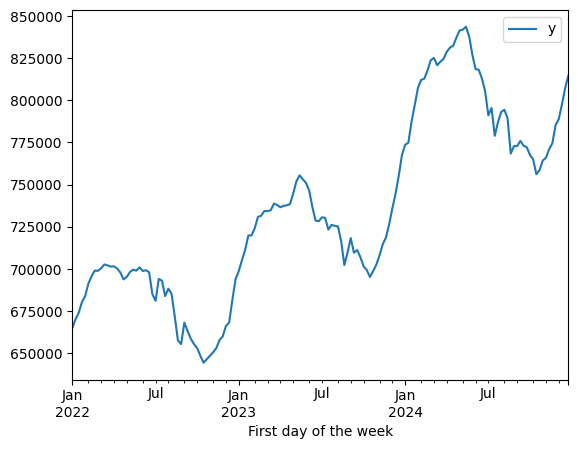

In [35]:
data["forecast"].plot()

## Prophet Model

In [36]:
data["model_prophet"] = data["forecast"]

In [37]:
data["model_prophet"].reset_index(inplace=True)

In [38]:
data["model_prophet"].columns = ["ds", "y"]

In [39]:
data["model_prophet"].head()

,ds,y
0,2022-01-03,665032.23
1,2022-01-10,670191.95
2,2022-01-17,674053.09
3,2022-01-24,680375.89
4,2022-01-31,683891.50


In [43]:
model_prophet = Prophet()
model_prophet.fit(data["model_prophet"])
data["forecast_prophet"] = model_prophet.predict()

19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
data["model_prophet"]["yhat"] = data["forecast_prophet"]["yhat"]

<Axes: xlabel='ds'>

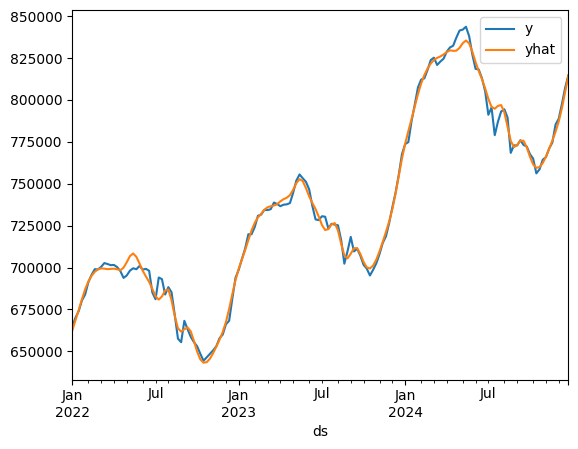

In [47]:
data["model_prophet"].plot(x = 'ds')

In [48]:
# Okay, for this course result seems fair enough

### Prophet Model Forecast

In [51]:
data["model_prophet"].drop('yhat',axis = 1)

,ds,y
0,2022-01-03,665032.23
1,2022-01-10,670191.95
2,2022-01-17,674053.09
3,2022-01-24,680375.89
4,2022-01-31,683891.50
...,...,...
151,2024-11-25,785276.74
152,2024-12-02,788802.73
153,2024-12-09,797591.73
154,2024-12-16,807265.18


In [54]:
model_prophet = Prophet()
model_prophet.fit(data["model_prophet"])
data["forecast_prophet"] = model_prophet.make_future_dataframe(periods = 52, freq="ME")
data["forecast_prophet"] = model_prophet.predict()

19:08:32 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
data["forecast_prophet"].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-03,656630.114000,657437.536097,668068.324989,656630.114000,656630.114000,5982.994999,5982.994999,5982.994999,5982.994999,5982.994999,5982.994999,0.0,0.0,0.0,662613.108998
1,2022-01-10,657050.051280,663247.539511,673771.911591,657050.051280,657050.051280,11633.566853,11633.566853,11633.566853,11633.566853,11633.566853,11633.566853,0.0,0.0,0.0,668683.618133
2,2022-01-17,657469.988559,669340.220529,680202.148556,657469.988559,657469.988559,17286.404950,17286.404950,17286.404950,17286.404950,17286.404950,17286.404950,0.0,0.0,0.0,674756.393509
3,2022-01-24,657889.925839,675662.608530,686093.100139,657889.925839,657889.925839,23203.709689,23203.709689,23203.709689,23203.709689,23203.709689,23203.709689,0.0,0.0,0.0,681093.635528
4,2022-01-31,658309.863119,682207.842546,692016.687707,658309.863119,658309.863119,28682.286105,28682.286105,28682.286105,28682.286105,28682.286105,28682.286105,0.0,0.0,0.0,686992.149224


In [56]:
data["model_prophet"]["yhat"] = data["forecast_prophet"]["yhat"]
data["model_prophet"]["yhat_lower"] = data["forecast_prophet"]["yhat_lower"]
data["model_prophet"]["yhat_upper"] = data["forecast_prophet"]["yhat_upper"]
data["model_prophet"]["trend"] = data["forecast_prophet"]["trend"]

<Axes: xlabel='ds'>

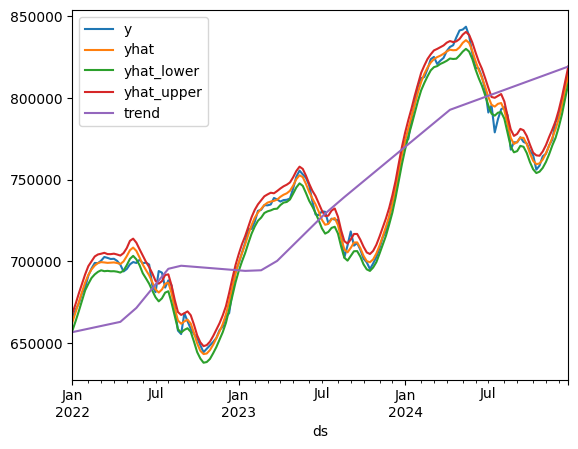

In [57]:
data["model_prophet"].plot(x='ds')

In [ ]:
# For now seems good enough